<center><h1>QBUS2820 - Predictive Analysis - 2024S1</h1></center>

<br/>

# I. Executive summary
The Consumer Price Index (CPI) is commonly used as a measure of inflation and deflation (Reserve Bank Of Australia, 2024). Therefore, forecasting CPI is a critical task because it provides an indication of the future economic conditions. Additionally, accurate CPI forecasts are valuable for the strategic planning of policy adjustments, thereby assisting the government in influencing the economy effectively.

This analysis will explore various methods for predicting the future quarterly CPI. The model that achieves the best forecast accuracy will be selected based on the mean squared error (MSE). This chosen model will then be used to forecast CPI data from Jan 2020 to Dec 2021.


# II. Data Cleaning and  Exploratory Data Analysis

In [1]:
# Import some external libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import pandas as pd
import statsmodels as sm
import statsmodels.api as smt
from pandas.plotting import autocorrelation_plot

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

## 1. Data cleaning

In [3]:
# Load the training data in
D_train = pd.read_csv('CPI_train.csv', index_col='Quarter', parse_dates=True, dayfirst=False)
D_train.index=D_train.index.to_period(freq='Q') # converting the index to quarterly period instead of dates
D_train

,CPI
Quarter,
1990Q1,89.1
1990Q2,90.1
1990Q3,90.4
1990Q4,93.8
1991Q1,93.0
...,...
2018Q4,127.8
2019Q1,125.8
2019Q2,126.6


In [4]:
# Check for missing values
D_train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 120 entries, 1990Q1 to 2019Q4
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [5]:
# Check for duplicated values 
D_train.duplicated().sum()

24

In [6]:
D_traind = D_train.copy()
D_traind.index=D_train.index.to_timestamp()
D_traind

,CPI
Quarter,
1990-01-01,89.1
1990-04-01,90.1
1990-07-01,90.4
1990-10-01,93.8
1991-01-01,93.0
...,...
2018-10-01,127.8
2019-01-01,125.8
2019-04-01,126.6


In [7]:
y_d = D_traind['CPI']
y = D_train['CPI']

## Comment
- Based on the analysis, the training dataset is in good condition. There are no missing values or invalid entries in the CPI data, which means that no data cleaning is required.
- Despite the absence of missing values, 24 duplicated values were detected. However, duplicate values can often represent valid data points rather than errors  in a time series like CPI. For example, it is possible for two consecutive quarters to have the same index value if there was no change in price levels. Removing these duplicates might misrepresent the stability of prices over time. Therefore, due to the nature of CPI, it is generally not recommended to drop duplicates as it can distort analysis
- As a result, no values are removed, the final sample contains 120 observations

In [8]:
y.describe().round(4)

count    120.0000
mean     112.4675
std       11.0543
min       89.1000
25%      102.8250
50%      116.4500
75%      121.3250
max      129.7000
Name: CPI, dtype: float64

## 2. EDA and Time series decomposition

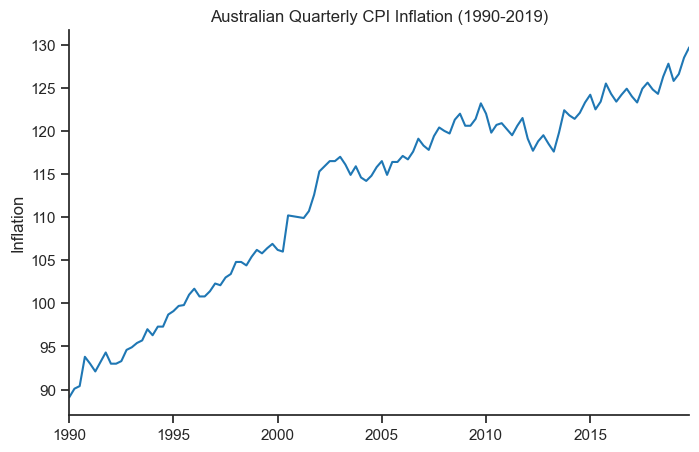

In [9]:
# Original time series plot of CPI (1990-2019)
fig, ax= plt.subplots(figsize=(8,5))
y.plot()
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation (1990-2019)')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

## Comment
- From the graph, it is apparent that there has been a notable increase in the level (i.e. the mean) of inflation over time. The variance, however, has been mostly steady with a slight rise observed in the latest period. 
- Detailed discussion of these characteristics will follow.

In [10]:
# Import external library
import statsmodels.tsa.seasonal
window_size = 4
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(y_d, filt=np.repeat(1/window_size, window_size))

## Comment

- Since the data is quarterly,  it is anticipated that seasonal patterns will extend across four quarters. Therefore, a window size of 4 is often suitable for capturing the cyclical patterns that repeat every year.
- Furthermore, CPI is typically influenced by factors such as seasonal variations in prices and annual changes in economic policies. Given these observations, a window size of 4 seems appropriate. This window size will allow the seasonal decomposition to capture the seasonal patterns effectively.


In [11]:
dir(decomposition)[-6:]

['observed', 'plot', 'resid', 'seasonal', 'trend', 'weights']

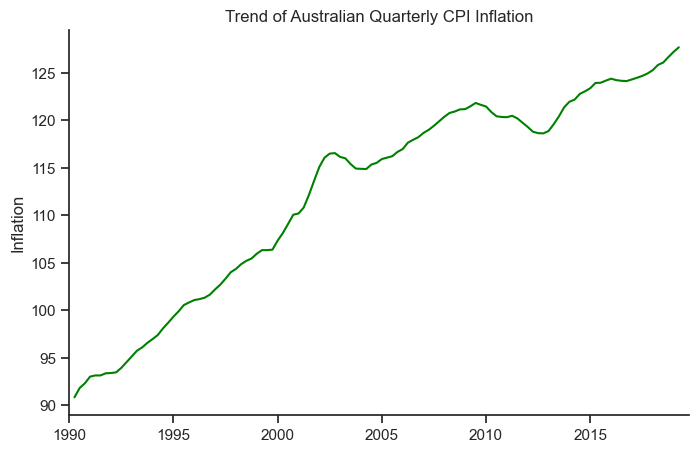

In [12]:
# Plot the trend of Australian quarterly CPI
fig, ax= plt.subplots(figsize=(8,5))
decomposition.trend.plot(color="green")
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Trend of Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

In [13]:
# Generate seasonally adjusted quarterly CPI
deseasonalized_data = decomposition.observed - decomposition.seasonal

In [14]:
deseasonalized_data.tail()

Quarter
2018-10-01    127.112795
2019-01-01    125.727450
2019-04-01    127.271961
2019-07-01    128.587795
2019-10-01    129.012795
Freq: QS-OCT, dtype: float64

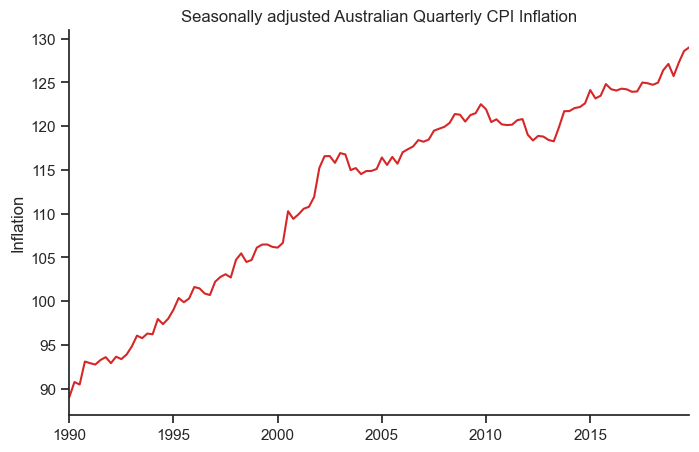

In [15]:
# Plot of seasonally adjusted CPI
fig, ax= plt.subplots(figsize=(8,5))
deseasonalized_data.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Seasonally adjusted Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

## Comment
- Seasonally adjusted data can be useful in some instances because it enables more meaningful comparisons of data across different periods.
- However, in this case, the unadjusted CPI data represent the true statistic of interest, as it accurately reflects the actual price movements observed on a quarterly basis. Given the nature of the data, it is not advisable to use seasonally adjusted data for model training (Fortier & Gellatly, 2024). Therefore, the original CPI time series will be used in this analysis.

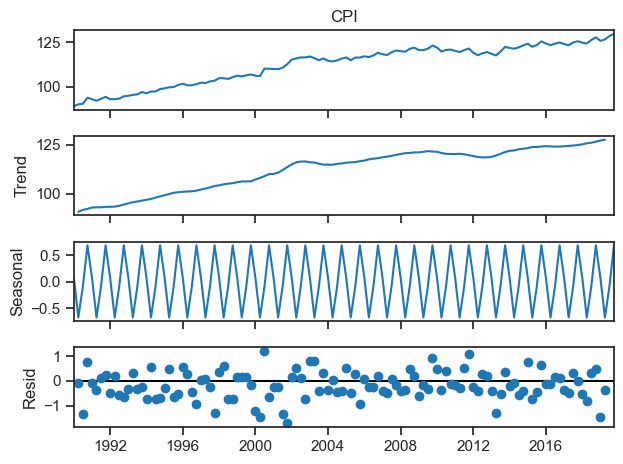

In [16]:
decomposition.plot()
plt.show()

# III Modelling and Training

Four candidate models will be constructed and analyzed. The final selection of the model will be based on a comprehensive evaluation of the advantages and drawbacks associated with each one.


## 1. Model 1 Simple Exponential Smoothing

In [17]:
# Fitting Model 1 SES
import forecast 

model1_ses=forecast.ses(y)
model1_ses.fit()

model1_ses.summary()

 Simple exponential smoothing

 Smoothing parameter:
 alpha  1.000 (0.091) 

 In-sample fit:
 MSE               1.368
 Log-likelihood   -189.088
 AIC               384.176
 BIC               392.539


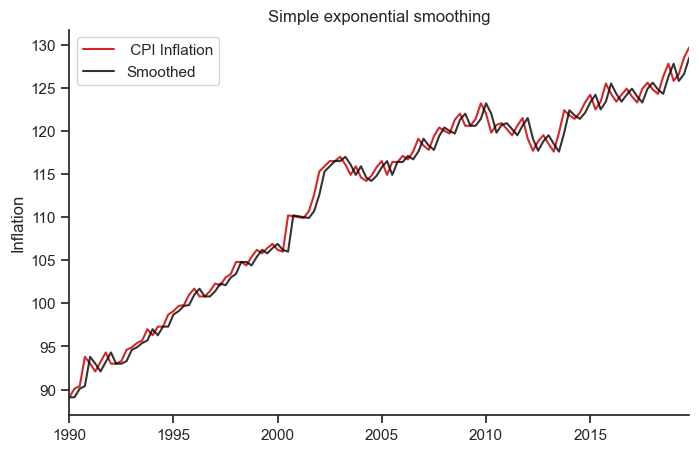

In [18]:
# Model 1 Fitted values vs Actual values
fitted1 = pd.Series(model1_ses.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(8,5))

y.plot(color=red, label=' CPI Inflation')
fitted1.plot(color='black', label='Smoothed', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Simple exponential smoothing')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Comment
- The smoothing parameter $\alpha$, is set close to 1, indicating that significantly more weight is given to recent observations compared to older ones. This weight allocation makes the forecasts more responsive to recent changes in the CPI.
- The graph indicates that the SES is relatively effective in tracking the trend of the original data over time. The smoothed line follows the general direction and shifts of the CPI despite not accounting for potential seasonal variations or more complex structural changes in the data.


## Model diagnostics

In [19]:
# Calculate residuals for SES
resid1 = y - fitted1

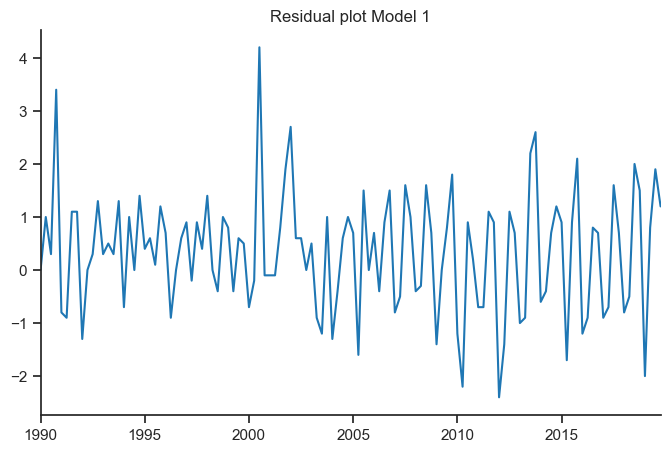

In [20]:
# Residual plot for SES
fig, ax= plt.subplots(figsize=(8,5))

resid1.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot Model 1')
sns.despine()
plt.show()

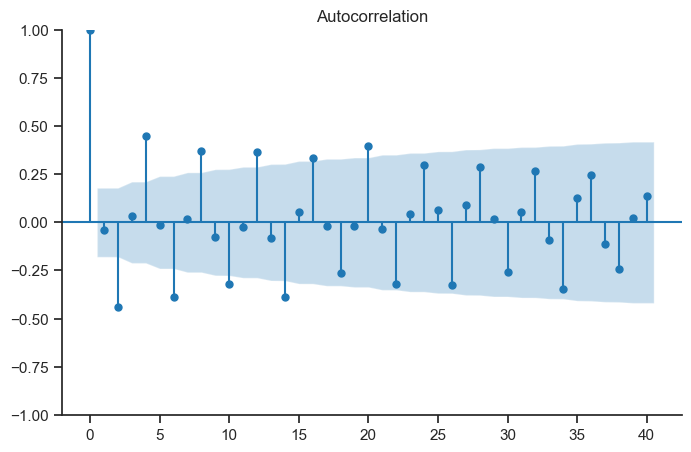

In [21]:
# Autocorrelation plot for SES residual
fig, ax = plt.subplots(figsize=(8,5))
smt.graphics.tsa.plot_acf(resid1, lags=40, ax=ax)
sns.despine()
plt.show()

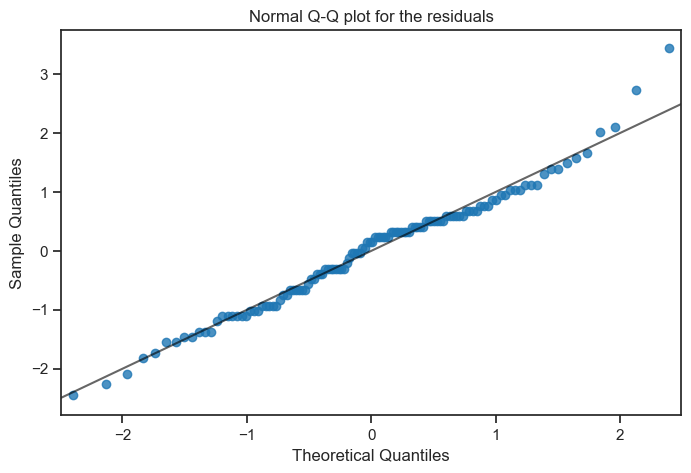

In [22]:
# Q-Q plot for residuals Model 1
from forecast import qq_plot

qq_plot(resid1)
plt.show()

## Comment
- The residual plot shows variations around zero that lack any clear pattern, suggesting random fluctuations. Furthermore, as can be seen from the autocorrelation plot, it is evident that the majority of the autocorrelations among residuals are within the confidence interval. These observations suggest that the model has adequately captured the time-dependent components in the data
- The residuals exhibit significant deviations from normality, demonstrated by the Q-Q plot where deviations occur in the tails. This indicates a violation of the normality assumption for the residuals, suggesting that alternative assumptions may be necessary for constructing confidence intervals and conducting hypothesis tests.


## 2. Model 2 Trend corrected exponential smoothing

In [23]:
# Fitting Model 2 
model2_holt = forecast.holt(y)
model2_holt.fit()
model2_holt.summary()

 Holt (trend corrected) exponential smoothing

 Smoothing parameters: 
 alpha (level) 0.865 (0.202)
 beta (trend)  0.029 (0.028)
 
 In-sample fit:
 MSE               1.302
 Log-likelihood   -186.116
 AIC               378.232
 BIC               386.595


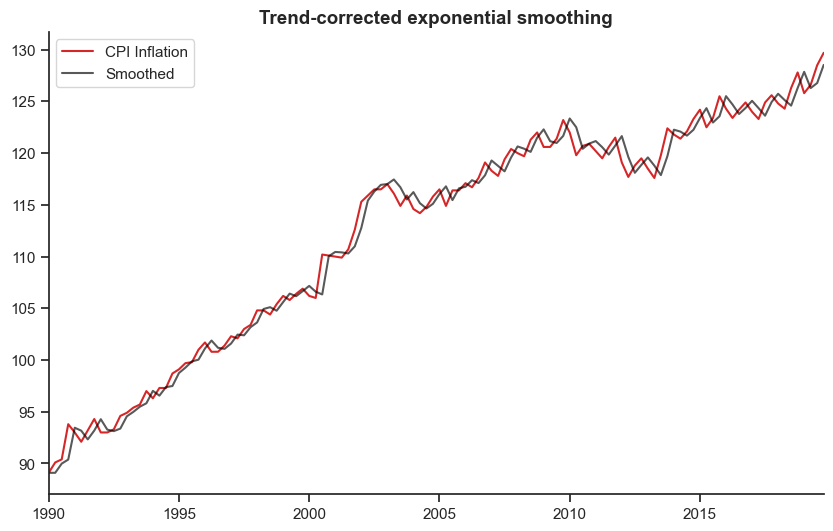

In [24]:
# Model 2 Fitted values vs Actual values
fitted2 = pd.Series(model2_holt.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='CPI Inflation')
fitted2.plot(color='black', label='Smoothed', alpha=0.65)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Trend-corrected exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Comment
- The trend-corrected exponential smoothing, which accounts for both the overall trend and seasonal variations, appears to fit CPI Inflation data slightly better than the SES. This is indicated by a marginally lower in-sample MSE of 1.302.


## Model diagnostics

In [25]:
# Calculate residuals for model 2
resid2 = y - fitted2

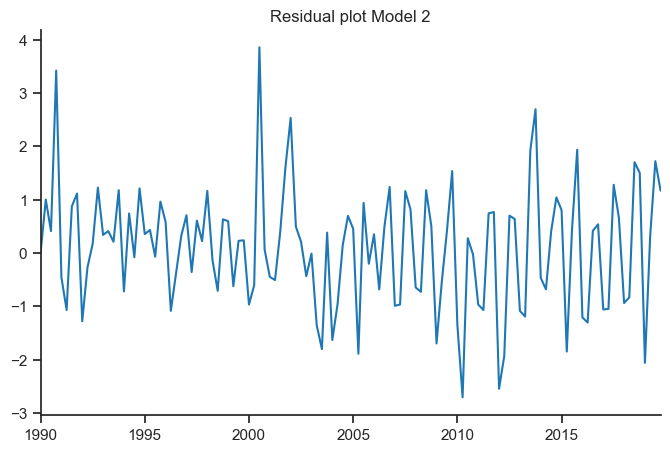

In [26]:
# Residual plot for trend-corrected smoothing
fig, ax= plt.subplots(figsize=(8,5))
resid2.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot Model 2')
sns.despine()
plt.show()

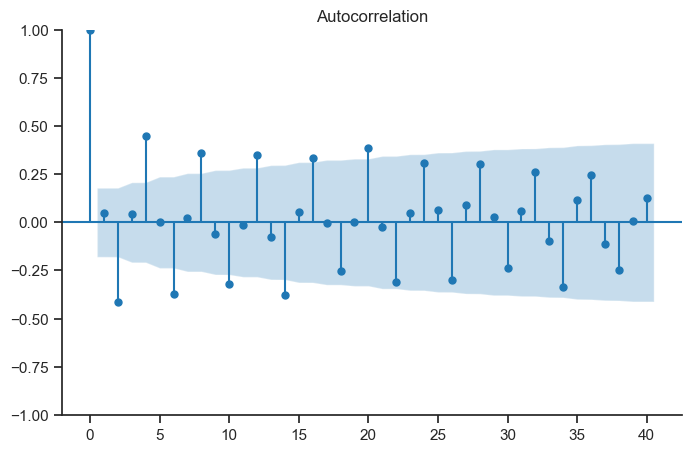

In [27]:
# Autocorrelation plot for trend corrected exponential smoothing residuals
fig, ax = plt.subplots(figsize=(8,5))
smt.graphics.tsa.plot_acf(resid2, lags=40, ax=ax)
sns.despine()
plt.show()

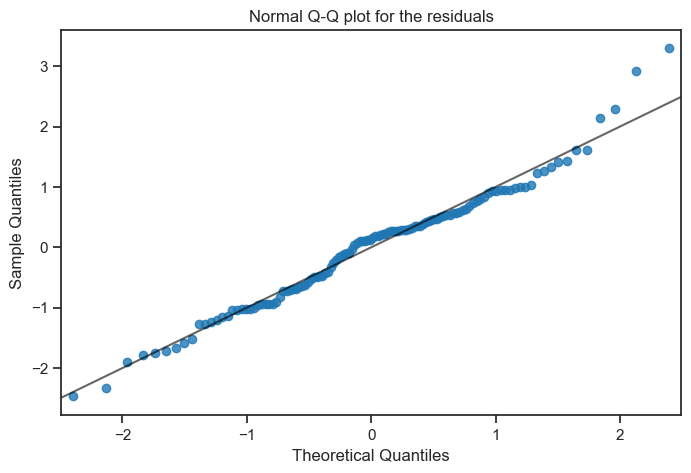

In [28]:
# Q-Q plot for residuals Model 2
from forecast import qq_plot

qq_plot(resid2)
plt.show()

## Comment
- Model 2's residuals show similarities to those of Model 1. Both models' residual plots exhibit random variations around zero without any clear patterns. This suggests that Model 2 is also a reasonable fit for the CPI data.
- Similar to Model 1, Model 2's residuals also do not perfectly follow a normal distribution, showing deviations especially in the tails of the Q-Q plot. This indicates the need for alternative assumptions when computing confidence intervals.


## 3. Model 3 Additive Holt-winters exponential smoothing

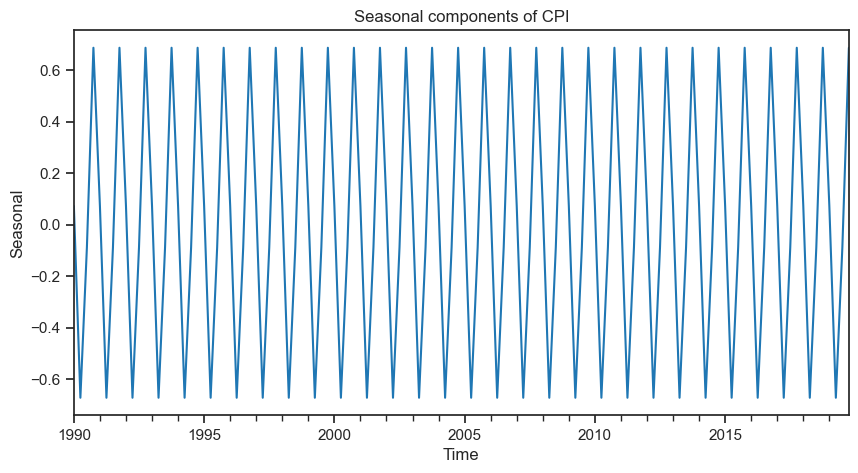

In [29]:
# Plot of the seasonal components
seasonal = decomposition.seasonal

fig, ax = plt.subplots(figsize=(10, 5))  
seasonal.plot(ax=ax)
ax.set_title('Seasonal components of CPI')
ax.set_ylabel('Seasonal')
ax.set_xlabel('Time')
plt.show()

## Comment 
- The plot demonstrates that the seasonal variations of the CPI data are consistent over time. This consistency suggests that additive smoothing is the appropriate method for capturing the patterns in the data, and it is likely to achieve the best performance.


In [30]:
# Fitting additive Holt-winters
ahw=forecast.holtwinters(y, additive=True, damped=False, m=4)
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.640 (0.095)
 beta  (trend)    0.049 (0.039)
 delta (seasonal) 0.950 (0.247)
 
 In-sample fit:
 MSE               1.187
 RMSE              1.089
 Log-likelihood   -180.552
 AIC               369.105
 BIC               380.254


In [31]:
# Fitting multiplicative Holt-winters 
mhw=forecast.holtwinters(y, additive=False, damped=False, m=4)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.630 (0.064)
 beta  (trend)    0.047 (0.043)
 delta (seasonal) 0.950 (0.194)
 
 In-sample fit:
 MSE               1.208
 RMSE              1.099
 Log-likelihood   -181.592
 AIC               371.184
 BIC               382.334


In [32]:
# Fitting additive damped
ahw=forecast.holtwinters(y, additive=True, damped=True, m=4)
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.635 (0.081)
 beta  (trend)    0.053 (0.038)
 delta (seasonal) 0.936 (0.238)
 phi (damping)    0.994 (0.020)
 
 In-sample fit:
 MSE               1.196
 RMSE              1.094
 Log-likelihood   -181.004
 AIC               372.008
 BIC               385.945


In [33]:
# Fitting multiplicative damped
mhw_damped=forecast.holtwinters(y, additive=False, damped=True, m=4)
mhw_damped.fit()
mhw_damped.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.625 (0.082)
 beta  (trend)    0.051 (0.042)
 delta (seasonal) 0.937 (0.232)
 phi (damping)    0.994 (0.017)
 
 In-sample fit:
 MSE               1.217
 RMSE              1.103
 Log-likelihood   -182.036
 AIC               374.072
 BIC               388.010


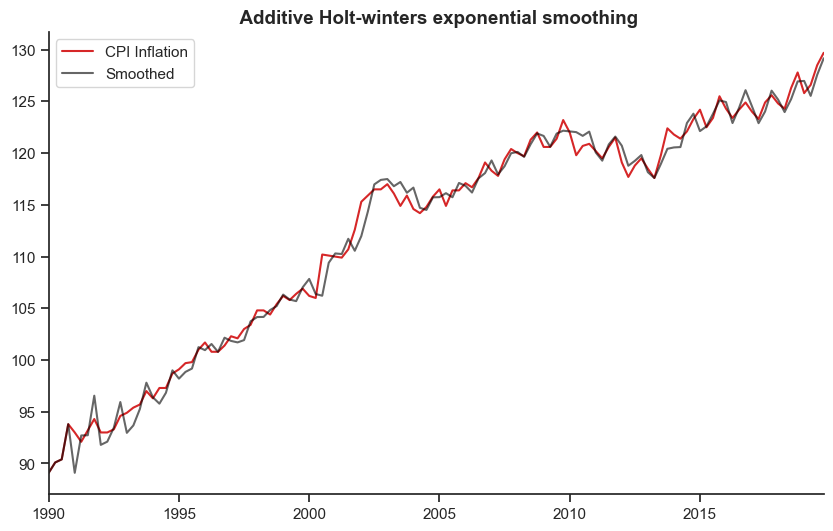

In [34]:
# Model 3 Fitted values vs Actual values
fitted3 = pd.Series(ahw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='CPI Inflation')
fitted3.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r' Additive Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

## Comment
- As anticipated, additive Holt-Winters smoothing outperforms other methods, including multiplicative, damped additive, and damped multiplicative smoothing. It achieves the lowest AIC and in-sample MSE values of 369.105 and 1.187, respectively.
- As a result, the additive Holt-Winters smoothing will be chosen as Model 3


## Model diagnostics

In [35]:
# Calculate residuals for model 2
resid3 = y - fitted3

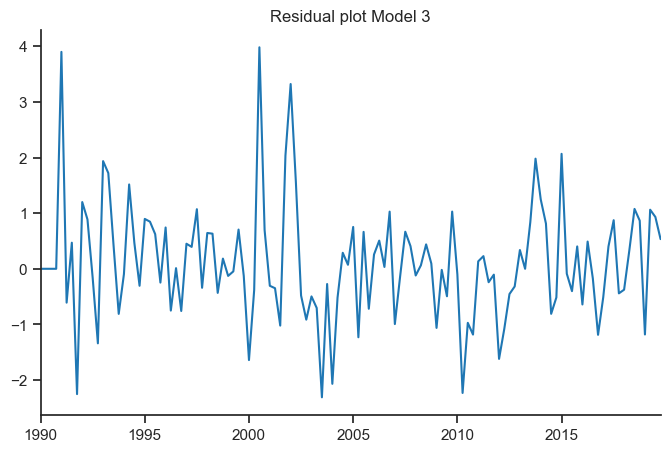

In [36]:
# Residual plot for additive Holt-Winters smoothing
fig, ax= plt.subplots(figsize=(8,5))
resid3.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot Model 3')
sns.despine()
plt.show()

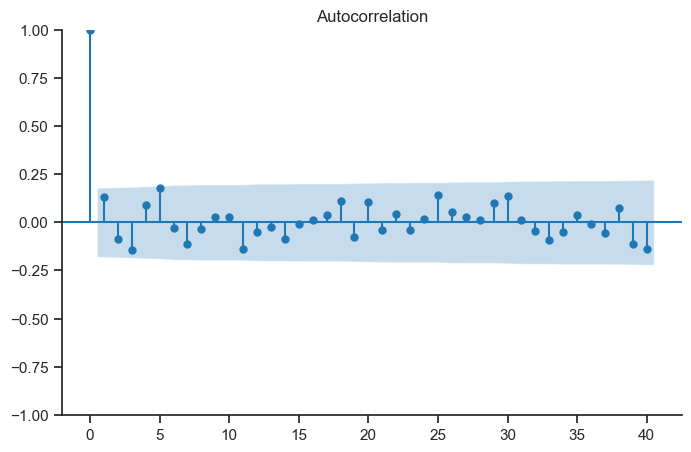

In [37]:
# Autocorrelation plot for Model 3 residuals
fig, ax = plt.subplots(figsize=(8,5))
smt.graphics.tsa.plot_acf(resid3, lags=40, ax=ax)
sns.despine()
plt.show()

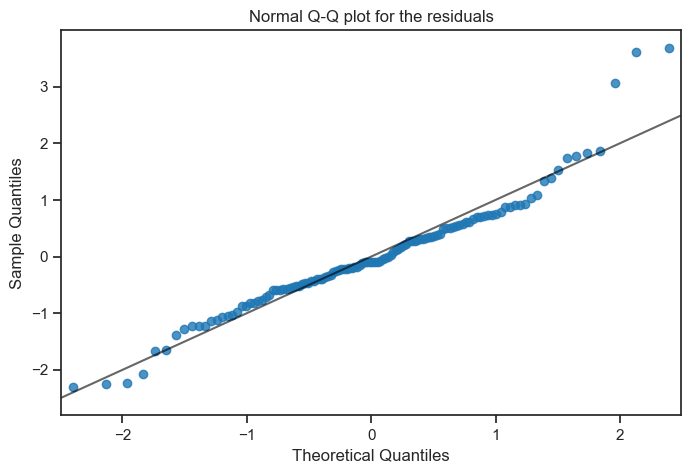

In [38]:
# Q-Q plot for residuals Model 3
from forecast import qq_plot

qq_plot(resid3)
plt.show()

## Comment
- Considering the significantly lower autocorrelations among residuals, additive Holt-winters exponential smoothing seems to be a better fit compared to the previous models

## 4. Model 4 & 5 ARIMA Model

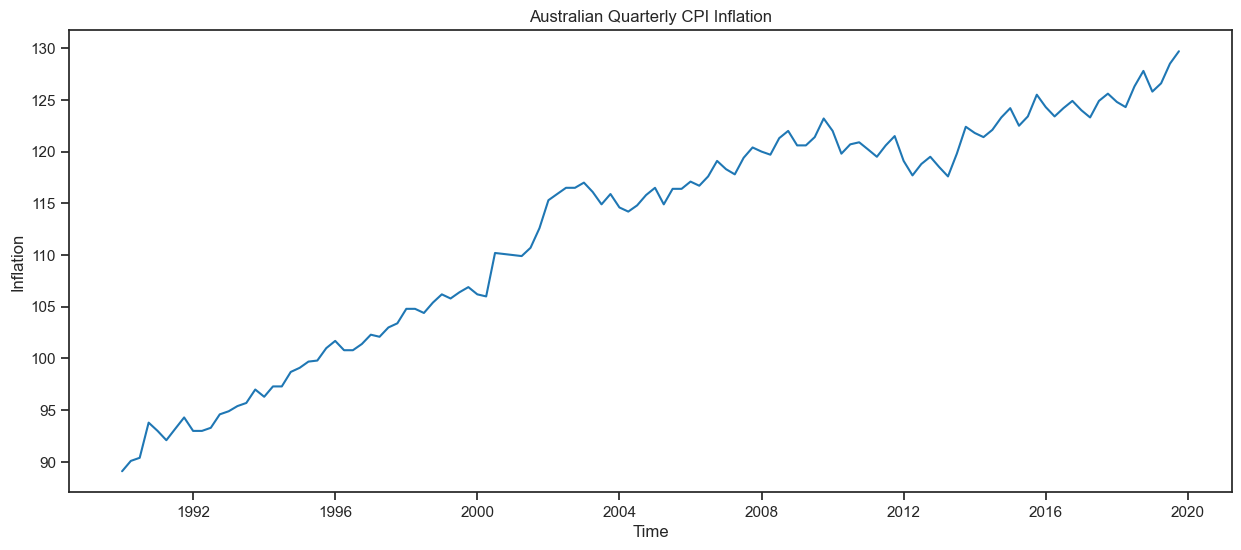

In [39]:
# Plot the original time series
plt.figure(figsize = (15,6))
plt.plot(y_d.index, y_d)
plt.xlabel('Time')
plt.ylabel('Inflation')
plt.title('Australian Quarterly CPI Inflation')
plt.show()

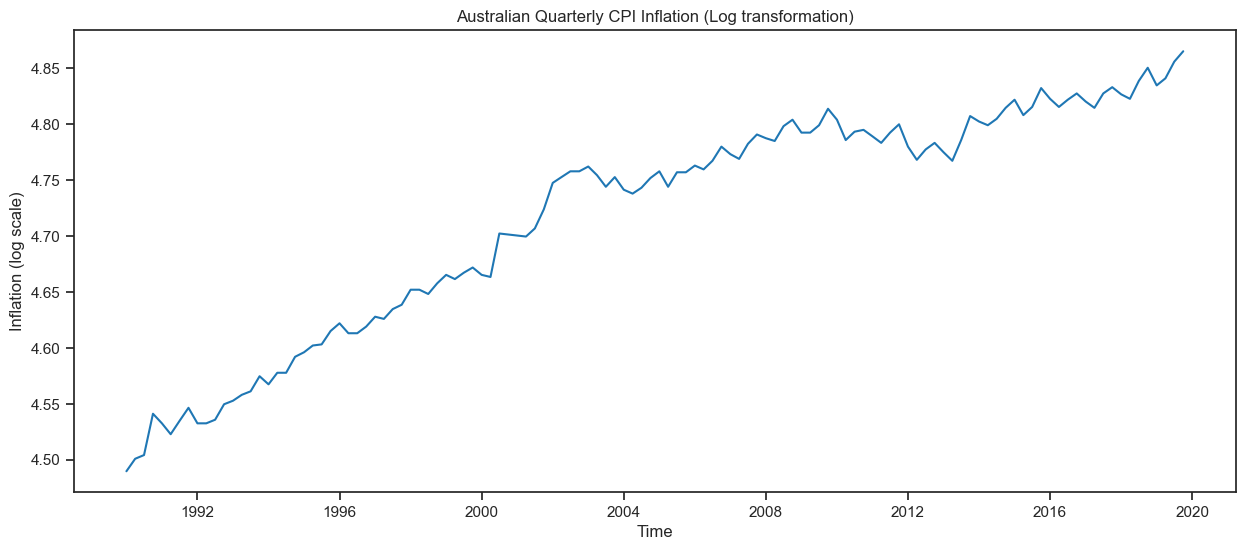

In [40]:
# Apply log transform and plot the new series
yd_log = np.log(y_d) 
plt.figure(figsize = (15,6))
plt.plot(y_d.index, yd_log)
plt.xlabel('Time')
plt.ylabel('Inflation (log scale)')
plt.title('Australian Quarterly CPI Inflation (Log transformation)')
plt.show()

## Comment
- As previously discussed, in terms of variance, the spread of data around the trend line seems to increase slightly during periods of rapid increases in the inflation, particularly after 2000 and around 2016. Other time periods such as before 2000 and after 2016, where the data stabilises, the variance remains relatively constant. 
- Given the consistent variance observed over time, a variance stabilising transformation might not be necessary. Supporting this expectation, the log quarterly CPI in Australia shows minor improvements compared to the original data.


### Inspect ACF and PACF plots

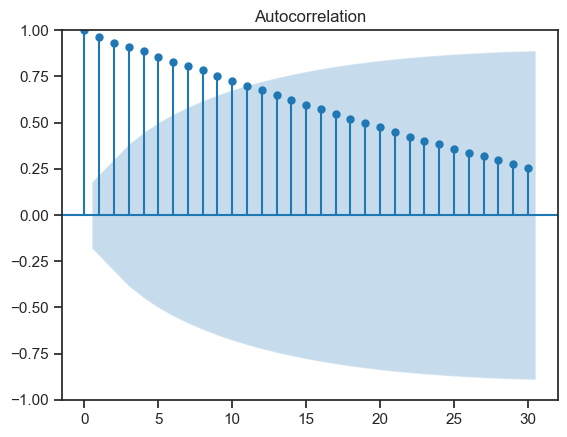

In [41]:
# Plot the ACF for the data. This call opens a new plot
smt.graphics.tsa.plot_acf(D_train, lags=30, alpha = 0.05)
plt.show()

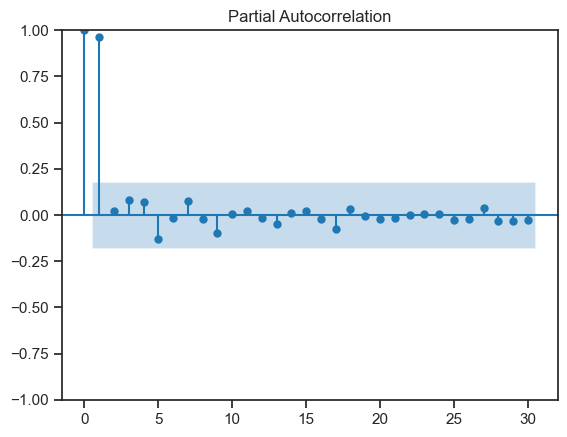

In [42]:
# Plot the PACF for the data. This call opens a new plot
smt.graphics.tsa.plot_pacf(D_train, lags=30, alpha=0.05)
plt.show()

## Comment
- The ACF appears to die down slowly. The gradual decrease in autocorrelation values as shown in the ACF suggests that the time series is likely non-stationary. This indicates that the data's mean or variance may change over time. 
- Time series with this type of ACF pattern might be well modelled by ARIMA. 


### Taking the $1^{st}$ differencing

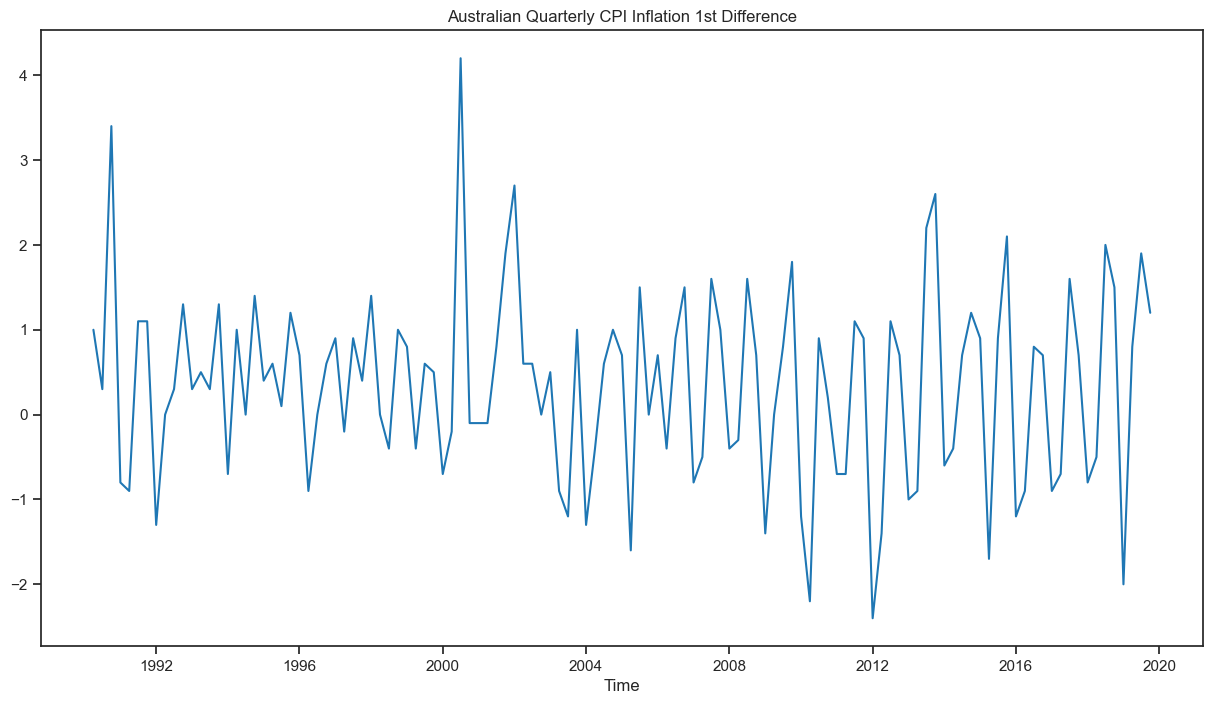

In [43]:
# take the 1st order diff
yd_diff = y_d - y_d.shift()
yd_diff.dropna(inplace=True)

# Plot the 1st-differencing series
plt.figure(figsize = (15,8))
plt.plot(yd_diff)
plt.title("Australian Quarterly CPI Inflation 1st Difference")
plt.xlabel('Time')
plt.show()

### ACF and PACF of the $1^{st}$ differencing data

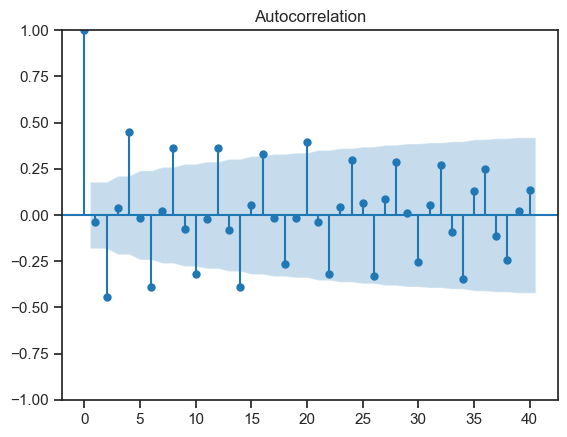

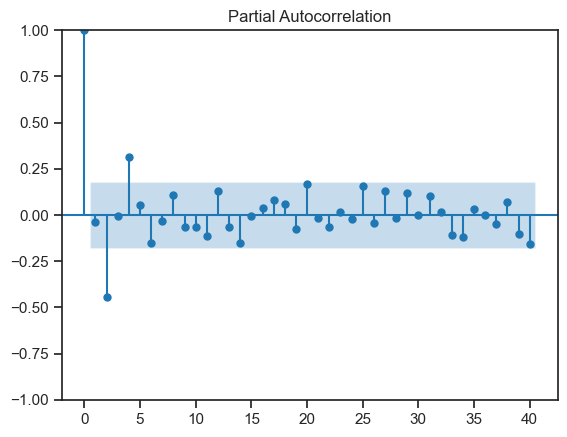

In [44]:
# ACF of the 1st differencing data
smt.graphics.tsa.plot_acf(yd_diff, lags=40, alpha = 0.05)
plt.show()

# PACF of the 1st differencing data
smt.graphics.tsa.plot_pacf(yd_diff, lags=40, alpha = 0.05)
plt.show()

In [45]:
# Conduct Augmented Dickey-Fuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(yd_diff)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -4.3104273226982
p-value: 0.0004261012875312279


## Comment
- After taking the first-order difference, the ACF dies down much more quickly, indicated by autocorrelations rapidly falling within the confidence interval. This is a strong indicator of stationarity 
- The PACF shows a few significant lags initially, but then quickly cuts off after lag 5, providing additional evidence of stationarity.
- To further check for the stationarity of the time series, Augmented Dickey-Fuller test was conducted. We set $\alpha = 5\%$ as standard. Since $p-value$ < $\alpha$, we reject the null and conclude that the time series is stationary.
- Therefore, the suitable integrated value d in this case is 1

### 4.1 Using AIC to select orders (p,q)

In [46]:
import statsmodels.tsa.stattools as st 
import warnings
warnings.filterwarnings("ignore") # turing off Python warning about future release related to the following code

order = st.arma_order_select_ic(yd_diff,max_ar=4,max_ma=4,ic=['aic'])
order

{'aic':             0           1           2           3           4
 0  369.533222  370.427060  357.739444  358.456335  350.049641
 1  371.356838  368.399995  359.631040  356.870969  352.038132
 2  346.989843  348.978091  322.556387  324.064108  326.061994
 3  348.959449  347.966301  324.065350  326.543942  327.967534
 4  336.445556  338.275585  326.060516  328.018269  329.798313,
 'aic_min_order': (2, 2)}

## Comment
- The method utilised to determine order p for AR process and order q for MA process in Model 4 involves minimising AIC. Research indicates that in most cases, the orders for AR and MA processes do not exceed 3, as higher orders may lead to overfitting and complicate model interpretability (Hyndman & Athanasopoulos, 2018). Additionally, models with higher orders can be computationally expensive and time-consuming. Therefore, the maximum orders for both processes were set at 3. 
- According to the result, the best fitting orders are p = 2 and q = 2.  As a result, Model 4 is ARIMA (2, 1, 2)

### Model 4 ARIMA (2, 1, 2)

In [47]:
# Import ARIMA class
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create an ARIMA (2,1,2) model
p,q = 2,2
model4 = ARIMA(y, order=(p, 1, q))
model4_fit = model4.fit()

# Summary of fit model
print(model4_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  120
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -164.142
Date:                Tue, 02 Dec 2025   AIC                            338.284
Time:                        21:27:24   BIC                            352.179
Sample:                    03-31-1990   HQIC                           343.926
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0143      0.030     -0.480      0.632      -0.073       0.044
ar.L2         -0.9939      0.016    -62.103      0.000      -1.025      -0.963
ma.L1          0.0144      0.096      0.150      0.8

## Model diagnostics

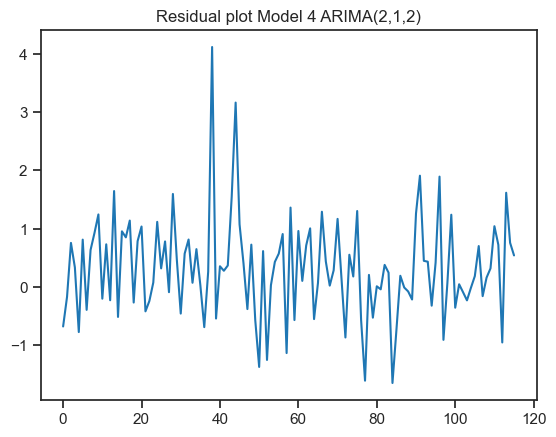

In [48]:
residuals4 = pd.DataFrame(model4_fit.resid)
# Remove the first 4 observations as they are for initialisitation only
resid4 = residuals4.values[4:] 

# Plot residuals of Model 4 ARIMA(2,1,2)
plt.figure()
plt.plot(resid4)
plt.title('Residual plot Model 4 ARIMA(2,1,2)')
plt.show()


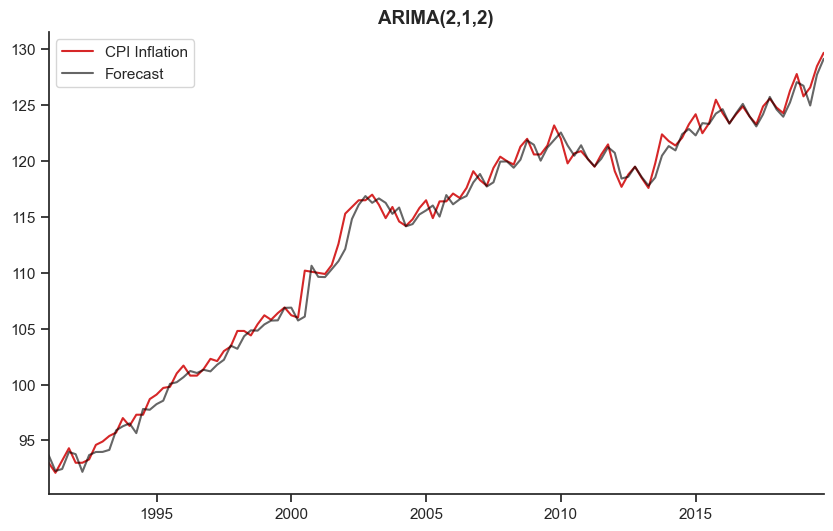

In [49]:
# Get Fitted values
fitted4 = model4_fit.predict(typ = 'levels', dynamic = False)

# # Model 4 Fitted values vs Actual values

fig, ax= plt.subplots(figsize=(10,6))

y[4:].plot(color='#D62728', label='CPI Inflation')
fitted4[4:].plot(color='black', label='Forecast', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'ARIMA(2,1,2)', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

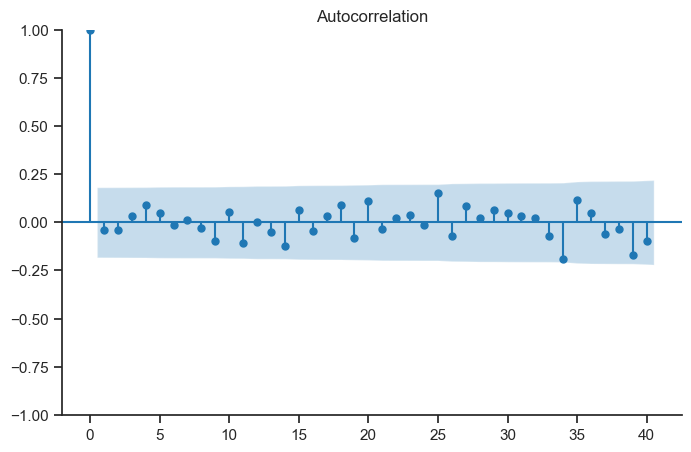

In [50]:
# Autocorrelation plot for Model 4 ARIMA(2,1,2)  residuals
fig, ax = plt.subplots(figsize=(8,5))
smt.graphics.tsa.plot_acf(resid4, lags=40, ax=ax)
sns.despine()
plt.show()

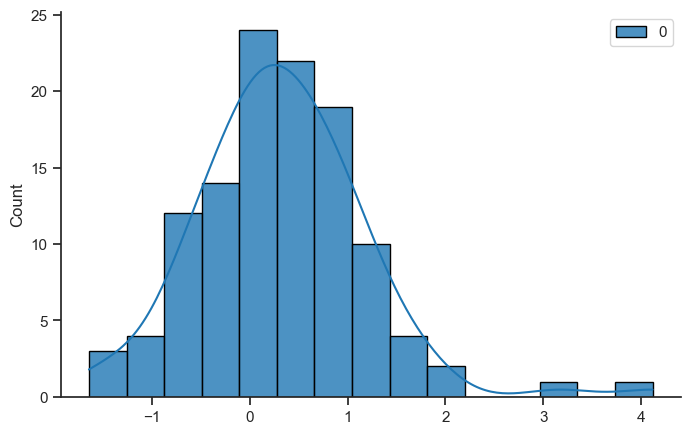

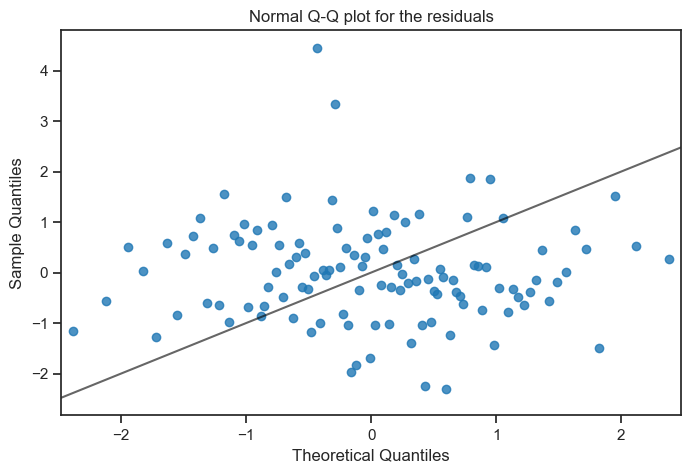

In [51]:
# Q-Q plot and histogram for residuals Model 4 ARIMA(2,1,2)

from forecast import histogram, qq_plot

histogram(resid4)
plt.show()

qq_plot(resid4)
plt.show()


## Comment
- As can be seen from the plot, the ARIMA model with p = 2 and q = 2 closely tracks the original series. Furthermore, the autocorrelation plot displays very low autocorrelations among the residuals, indicating that an ARIMA model with an order of 2 for both the AR and MA processes is a good fit to the CPI time series.
- However, the Q-Q plot and histogram of the residuals do not indicate normality, suggesting that alternative assumptions are required for computing the confidence intervals.

### 4.2 Using MSE to select orders (p,q)

In [52]:
from sklearn.metrics import mean_squared_error


y_q = D_train['CPI']
validation=y_q['2016Q1':].index
start = y_q.index.get_loc('2016Q1') 


# Define the range for p and q
max_ar = 3
max_ma = 3

min_mse = np.inf
best_order = None
pred = {}
mse = {}
# Iterate over all combinations of p and q

for p in range(max_ar+1):
    for q in range(max_ma+1):
        orders = (p,q)
        pred[orders] = []
        mse_scores = []
        actual= []
        
        # Loop over the data to find orders that minimize MSE
        for i in range(start, len(y_q)-8):
            
            actual.append(y_q.iloc[i:i+8]) # actual value
            
            # Fit the ARIMA models
            model = ARIMA(y_q.iloc[:i], order=(p,1,q)).fit()
            pred[orders].append(model.forecast(8))
    
            # Calculate mean MSE 
            mse[orders] = np.mean(mean_squared_error(actual, pred[orders]))

            # Determine the lowest MSE             
min_mse = min(mse.values())
best_order = min(mse, key=mse.get)  # Get the order with the minimum MSE
print(f'Best Order: {best_order}')
print(f'Minimum MSE: {min_mse}')

Best Order: (3, 3)
Minimum MSE: 0.9611766220556566


## Comment
- As mentioned earlier, the MSE will be used to evaluate the forecast accuracy of each model. Hence, the orders for the AR and MA processes in Model 5 will be chosen based on their ability to minimise the MSE.


### Model 5 ARIMA (3, 1, 3)

In [53]:
# Create an ARIMA (3,1,3) model
p,q = 3,3
model5 = ARIMA(y, order=(p, 1, q))
model5_fit = model5.fit()

# Summary of fit model
print(model5_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  120
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -157.196
Date:                Tue, 02 Dec 2025   AIC                            328.391
Time:                        21:27:42   BIC                            347.845
Sample:                    03-31-1990   HQIC                           336.291
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9822      0.024     41.273      0.000       0.936       1.029
ar.L2         -0.9792      0.028    -34.634      0.000      -1.035      -0.924
ar.L3          0.9916      0.016     62.349      0.0

## Model diagnostics

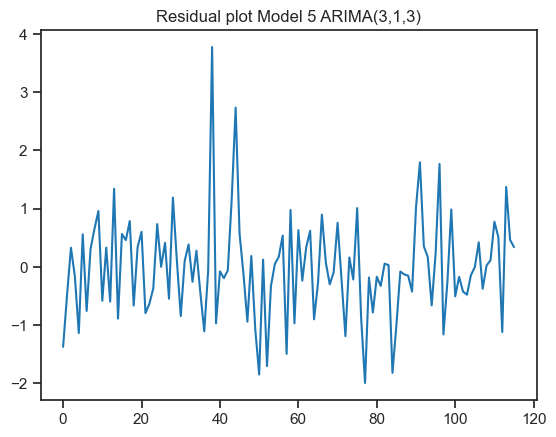

In [54]:
residuals5 = pd.DataFrame(model5_fit.resid)
# Remove the first 4 observations as they are for initialisitation only
resid5 = residuals5.values[4:]

# Plot residuals of Model 5 ARIMA(3,1,3)
plt.figure()
plt.plot(resid5)
plt.title('Residual plot Model 5 ARIMA(3,1,3)')
plt.show()

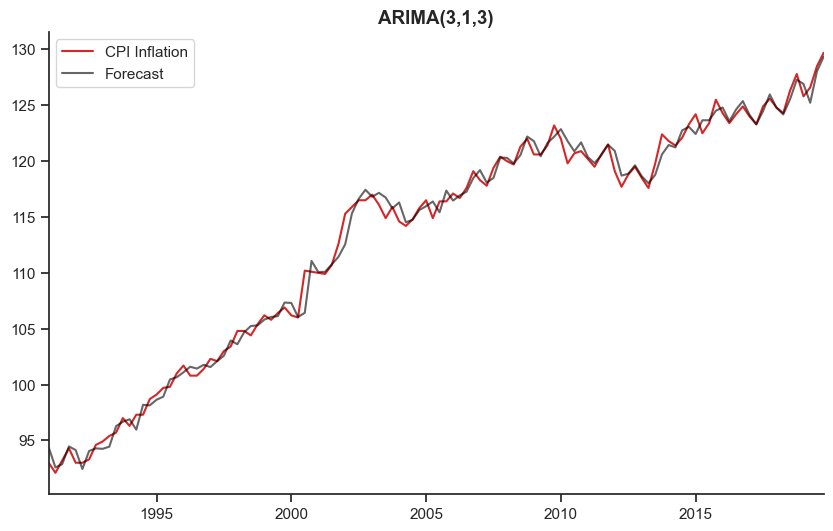

In [55]:
# Get Fitted values
fitted5 = model5_fit.predict(typ = 'levels', dynamic = False)

# # Model 5 Fitted values vs Actual values

fig, ax= plt.subplots(figsize=(10,6))

y[4:].plot(color='#D62728', label='CPI Inflation')
fitted5[4:].plot(color='black', label='Forecast', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'ARIMA(3,1,3)', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

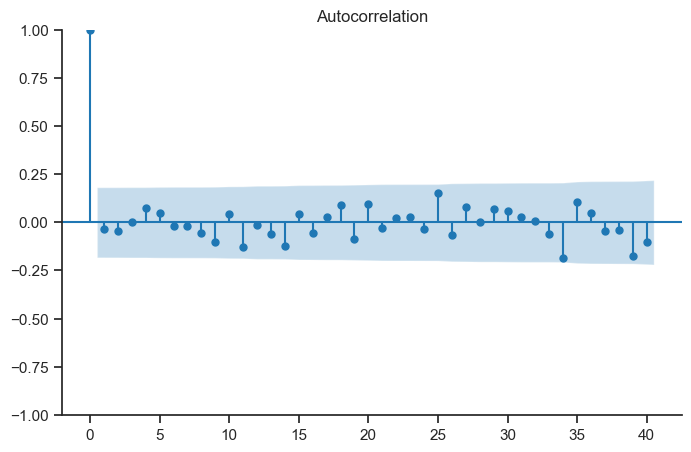

In [56]:
# Autocorrelation plot for Model 4 ARIMA(2,1,2)  residuals
fig, ax = plt.subplots(figsize=(8,5))
smt.graphics.tsa.plot_acf(resid5, lags=40, ax=ax)
sns.despine()
plt.show()

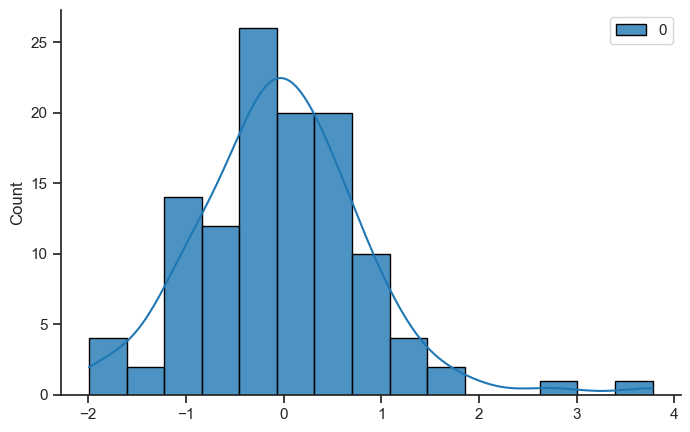

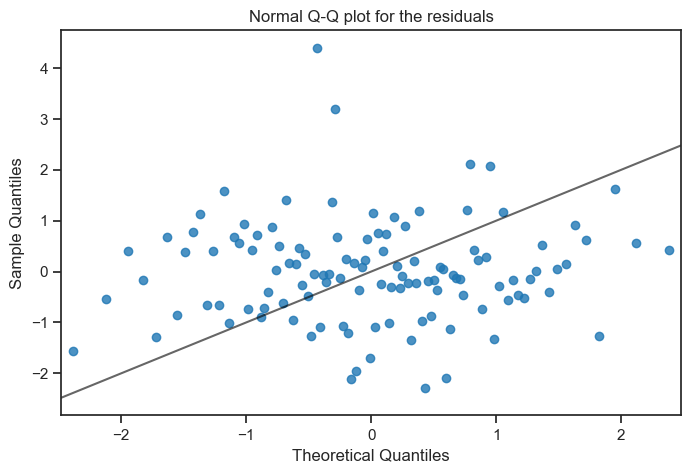

In [57]:
# Q-Q plot and histogram for residuals Model 4 ARIMA(2,1,2)

from forecast import histogram, qq_plot

histogram(resid5)
plt.show()

qq_plot(resid5)
plt.show()


## Comment
- Similar to Model 4, the ARIMA model with an order of 3 for both the AR and MA processes fits the CPI time series well as it closely captures the time series pattern in CPI data. However, like Model 4, Model 5 also violates the normality assumption for the residuals.


## 5. Model Validation

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

validation=y['2016Q1':].index
start = y.index.get_loc('2016Q1') 

pred1 = [] # simple exponential smoothing
pred2 = [] # trend corrected smoothing
pred3 = [] # additive holt winters
pred4 = [] # ARIMA(2,1,2)
pred5 = [] # ARIMA(3,1,3)
actual= []

for i in range(start, len(y)-8):
    
    actual.append(y.iloc[i:i+8]) # actual value
    
    # Model 1 SES
    model = forecast.ses(y.iloc[:i]) 
    model.fit()
    pred1.append(model.forecast(8)) # SES forecast
    
    # Model 2 
    model = forecast.holt(y.iloc[:i])
    model.fit()
    pred2.append(model.forecast(8)) # Trend corrected forecast
    
    # Model 3
    model = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=4)
    model.fit()
    pred3.append(model.forecast(8)) # Additive holt winters forecast
    
    # Model 4
    model = ARIMA(y.iloc[:i], order=(2,1,2)).fit()
    pred4.append(model.forecast(8)) # ARIMA(2,1,2) forecast
    
    # Model 5
    model = ARIMA(y.iloc[:i], order=(3,1,3)).fit()
    pred5.append(model.forecast(8)) # ARIMA(3,1,3) forecast
    

In [59]:
mse1 = np.zeros((8,1))
mse2 = np.zeros((8,1))
mse3 = np.zeros((8,1))
mse4 = np.zeros((8,1))
mse5 = np.zeros((8,1))
for i in range(8):
    mse1[i,0] = mean_squared_error(actual[i], pred1[i])
    mse2[i,0] = mean_squared_error(actual[i], pred2[i])
    mse3[i,0] = mean_squared_error(actual[i], pred3[i])
    mse4[i,0] = mean_squared_error(actual[i], pred4[i])
    mse5[i,0] = mean_squared_error(actual[i], pred5[i])
    
col = ['SES', 'Holt_exp', 'Additive', 'ARIMA(2,1,2)', 'ARIMA(3,1,3)']
summary = pd.DataFrame(0.0, index=col, columns=['MSE'])
summary['MSE'] = [mse1.mean(), mse2.mean(), mse3.mean(), mse4.mean(), mse5.mean()]
summary.round(4)

,MSE
SES,3.1509
Holt_exp,2.0016
Additive,1.1419
"ARIMA(2,1,2)",1.6697
"ARIMA(3,1,3)",0.9612


## Comment
- To evaluate the models' performance, 8-step ahead forecast model validation will be performed. The validation set consists of 12 data points from '2016Q1' to '2019Q4', accounting for 10% of the total sample size. Simultaneously, 90% of the data is retained for training, which ensures that bias remains within a reasonable range. This split is reasonable since it offers a good balance between variance and bias (James et al., 2023)
- Based on the results, Model 5 demonstrates the best performance, having the lowest MSE of 0.9612. Thus, Model 5 is selected for forecasting the quarterly CPI for the period from Jan 2020 to Dec 2021.

# III Forecasting

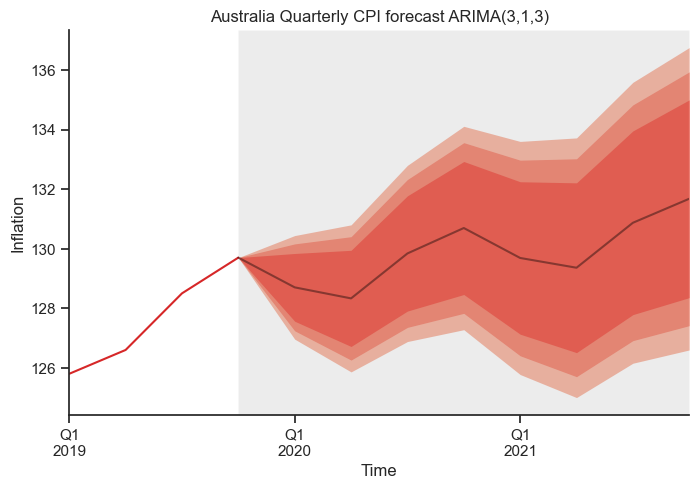

In [60]:
# Generate 8-step ahead forecast from 2020Q1 to 2021Q4
h = 8

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='Q')

predicted=pd.Series((model5_fit.forecast(h)), index=test)

interval1 = model5_fit.get_forecast(h).conf_int(alpha=0.2)
interval2 = model5_fit.get_forecast(h).conf_int(alpha=0.1)
interval3 = model5_fit.get_forecast(h).conf_int(alpha=0.05)


fig, ax = forecast.fanchart(y['2019Q1':], predicted, interval1, interval2, interval3)
ax.set_xlabel('Time')
ax.set_ylabel('Inflation')
ax.set_xticks([], minor=True)
plt.title('Australia Quarterly CPI forecast ARIMA(3,1,3)')

sns.despine()
plt.show()

# IV Test errors

In [70]:
# Forecast the quarterly CPI Jan 2020 to Dec 2021
predict_test = model5_fit.forecast(steps=8)
pred_CPI = pd.DataFrame(predict_test)
pred_CPI = pred_CPI.rename(columns={'predicted_mean': 'CPI'})
pred_CPI.index = pred_CPI.index.to_timestamp()
pred_CPI.head(8).round(4)

,CPI
2020-01-01,128.7013
2020-04-01,128.3312
2020-07-01,129.8399
2020-10-01,130.6937
2021-01-01,129.6881
2021-04-01,129.3602
2021-07-01,130.8695
2021-10-01,131.6759


In [79]:
# Calculate the test error
CPI_test = pd.read_csv('CPI_test.csv')
test_error = mean_squared_error(CPI_test['CPI'], pred_CPI['CPI'])
test_error = test_error.round(12)
print(test_error)

# V Discussion and Conclusion

The analysis undertaken in this report aims to forecast the quarterly Consumer Price Index (CPI) over the next two years. This task is crucial as it provides insights into expected inflation trends, which are vital for economic planning and policy-making. Forecasting CPI helps governments and central banks to adjust monetary policies appropriately, aids businesses in strategic planning and budgeting, and assists consumers in making informed financial decisions (Reserve Bank Of Australia, 2024).

Utilizing historical data and employing several data analysis techniques, including model selection, five candidate models were developed. Through model validation, Model 5 was identified as the most suitable choice among the models examined.

While Model 5 stands out as the selected model for forecasting quarterly CPI, it is crucial to acknowledge its limitations. Specifically, the model violates the normality assumption of residuals, highlighted by clear deviations in the Q-Q plot of residuals. In forecasting, the model's ability to capture the underlying data patterns and predict future values might still be effective despite the non-normality of residuals. However, for statistical inference, the deviation from normality could lead to less reliable estimates of the uncertainty such as unreliable confidence intervals. This means that the interval forecasts might not accurately represent the potential range of future values.

In conclusion, Model 5 demonstrates a robust capability to forecast the quarterly CPI for the upcoming two years, capturing the trends and seasonal patterns effectively. However, it is important to recognize the limitations of the ARIMA model with an order of 3 for both the AR and MA processes, especially when it comes to interval forecast.


# References
1. Fortier, S., & Gellatly, G. (2024). Seasonally Adjusted Data - Frequently Asked Questions. Statistics Canada. https://www150.statcan.gc.ca/n1/dai-quo/btd-add/btd-add-eng.htm
2. Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting : Principles and Practice (2nd ed., Vol. 8). Otexts. https://otexts.com/fpp2/
3. James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). An Introduction to Statistical Learning (pp. 229–288). Springer Nature.
4. Reserve Bank Of Australia. (2024). Measures of Consumer Price Inflation. Reserve Bank of Australia. https://www.rba.gov.au/inflation/measures-cpi.html